In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
from matplotlib.gridspec import GridSpec
from juliacall import Main as jl
import copy, pickle, io
from PIL import Image

Precompiling packages...
   9080.2 ms  ✓ JSON3
   2537.4 ms  ✓ CondaPkg
  24760.2 ms  ✓ PythonCall
  3 dependencies successfully precompiled in 36 seconds. 48 already precompiled.


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
jl.seval('using Pkg; Pkg.activate("/mnt/c/Users/Eiad/Documents/linux/julia/env")')

  Activating project at `/mnt/c/Users/Eiad/Documents/linux/julia/env`


In [65]:
jl.include("nsrl.jl")

In [4]:
def sobol_uniform(n, d):
    sampler = qmc.Sobol(d, scramble=False).fast_forward(1)
    return sampler.random(n)
    
def sobol_normals(n, d, eps=1e-12):
    U = sobol_uniform(n, d)
    # Clamp to avoid 0 or 1, which would lead to ±inf in inverse CDF
    U = np.clip(U, eps, 1 - eps)
    Z = norm.ppf(U)  # Elementwise inverse CDF (aka "probit")
    return Z

In [66]:
N = 50_000
Z = sobol_normals(N, 4)
Zx = Z[:, 0:2]
Zy = Z[:, 2:4]

epsilon_a = 7.7e-6
epsilon_b = 7.7e-6

beta_a = 7
beta_b = 8
alpha_a = -0.3
alpha_b = -0.8

Mx = np.array([[np.sqrt(beta_a), 0],
               [-alpha_a / np.sqrt(beta_a), 1/np.sqrt(beta_a)]])
My = np.array([[np.sqrt(beta_b), 0],
               [-alpha_b / np.sqrt(beta_b), 1/np.sqrt(beta_b)]])

coords_x = np.sqrt(epsilon_a) * (Zx @ Mx.T)
coords_y = np.sqrt(epsilon_b) * (Zy @ My.T)
coords_z = np.zeros((N, 2))

coords = np.hstack([coords_x, coords_y, coords_z])
# Pass coords back into Julia to construct Bunch
jl_coords = jl.Array(coords)
# Assume Bunch, Ta, R etc. are defined in nsrl.jl
b0 = jl.Bunch(jl_coords, species=jl.Ta, R_ref=jl.R)
bunch = jl.deepcopy(b0)

In [75]:
def hist(bunch, nx=80, ny=80, xlims=(-0.2, 0.2), ylims=(-0.2, 0.2), make_plot=True):
    # 1. Extract x, y positions
    coords = bunch.coords.v  # assuming bunch.coords.v is an (N, 6) NumPy array
    x = coords[:, 0]
    y = coords[:, 2]

    # 2. Determine limits
    if xlims is None:
        xlims = (min(x), max(x))
    if ylims is None:
        ylims = (min(y), max(y))

    # 3. Create histogram bin edges
    x_edges = np.linspace(xlims[0], xlims[1], nx + 1)
    y_edges = np.linspace(ylims[0], ylims[1], ny + 1)

    # 4. 2D Histogram
    H, x_edges, y_edges = np.histogram2d(x, y, bins=[x_edges, y_edges])
    H = H.astype(float)
    H[H == 0] = np.nan  # To match Julia's `NaN` for zero-weight bins

    if not make_plot:
        return {
            'hist': H,
            'x_edges': x_edges,
            'y_edges': y_edges
        }

    # 5. Bin centers
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

    # 6. Marginal histograms
    x_marginal = np.nansum(H, axis=1)  # sum along y-axis (rows)
    y_marginal = np.nansum(H, axis=0)  # sum along x-axis (cols)

    # 7. Create plot layout
    fig = plt.figure(figsize=(8.5, 8.5), constrained_layout=True)
    gs = GridSpec(2, 2, width_ratios=[0.8, 0.2], height_ratios=[0.2, 0.8],
                  wspace=0.05, hspace=0.05)

    # Top marginal (x)
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.fill_between(x_centers, x_marginal, alpha=0.5)
    ax_top.set_xlim(xlims)
    ax_top.set_ylabel("Count")
    ax_top.set_xticks([])

    # Right marginal (y)
    ax_right = fig.add_subplot(gs[1, 1])
    ax_right.fill_betweenx(y_centers, y_marginal, alpha=0.5)
    ax_right.set_ylim(ylims)
    ax_right.set_xlabel("Count")
    ax_right.set_yticks([])

    # Main 2D heatmap
    ax_main = fig.add_subplot(gs[1, 0])
    mesh = ax_main.pcolormesh(x_edges, y_edges, H.T, shading='auto', cmap='inferno')
    ax_main.set_xlabel("x (m)")
    ax_main.set_ylabel("y (m)")
    ax_main.set_aspect('auto')

    # Colorbar (optional)
    #fig.colorbar(mesh, ax=ax_main, orientation='vertical', fraction=0.05)

    # Blank plot (no frame, used for layout symmetry in Julia)
    # Not needed in matplotlib

    plt.suptitle("Beam profile at Target")
    plt.show()

    # Return data if needed
    return {
        'hist': H,
        'x_edges': x_edges,
        'y_edges': y_edges,
        'x_centers': x_centers,
        'y_centers': y_centers,
        'x_marginal': x_marginal,
        'y_marginal': y_marginal,
        'figure': fig
    }

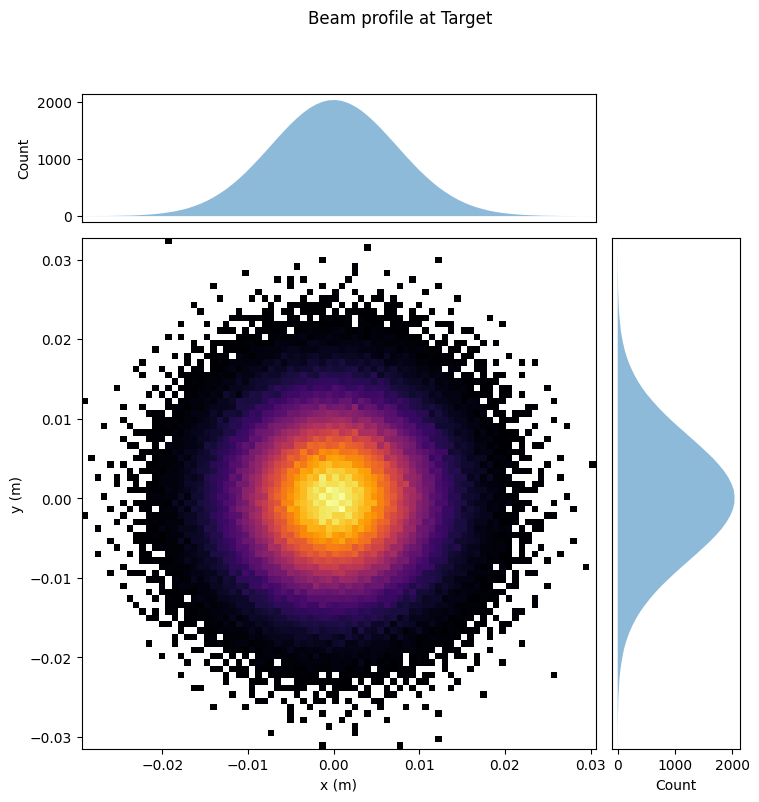

In [68]:
hist(bunch, nx=80, ny=80, xlims=None, ylims=None);

In [69]:
# Track the bunch through the beamline
jl.track_b(bunch, jl.nsrl)

Bunch{Float64, Float64, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}}(Species(#181Ta+73, charge=73.0e, mass=1.6851468800901855e11 eV/c², spin=90.5ħ), 7.203299138182853, 4.90967743121352e-7, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}(UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01  …  0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01], [1.3801293162048244e-15 -2.68658273817705e-17 … -7.771561172376097e-16 0.0; -0.01562603252607834 0.00031872058387485795 … 0.0003695925670970337 0.0; … ; -0.022121752266064682 0.0008001714910814478 … 0.0005559714511833507 0.0; -0.06906208278917504 -0.0003812086787469372 … 0.002199888200357318 0.0], nothing))

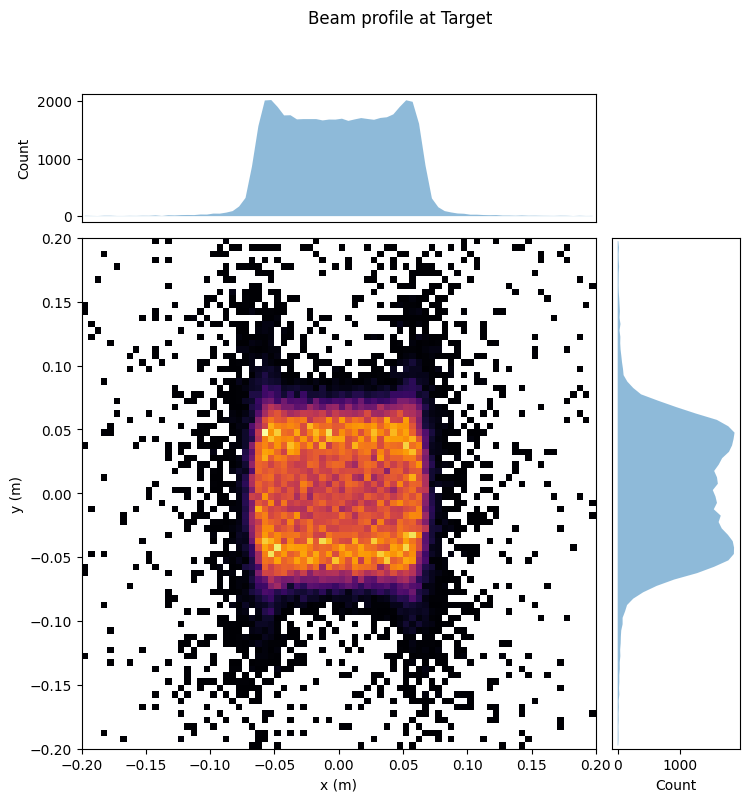

In [70]:
# Visualize tracked bunch
p0 = hist(bunch, nx=80, ny=80)

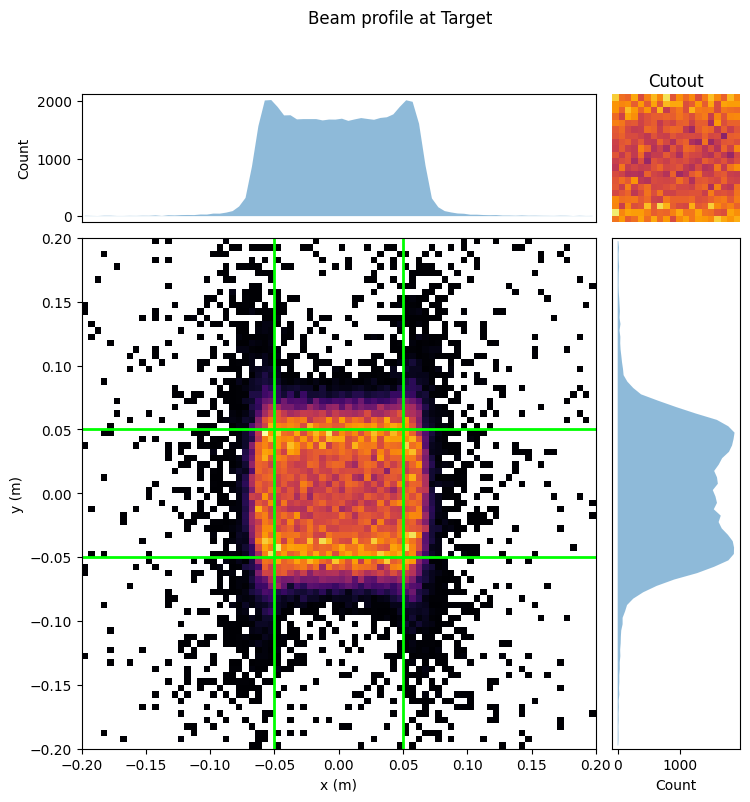

In [71]:
# Define box dimensions
v = 0.05
h = 0.05

# Extract data from the returnd dictionary
buf = io.BytesIO()
pickle.dump(p0['figure'], buf)
buf.seek(0)
fig = pickle.load(buf) #p0['figure']
hist_data = p0['hist']
x_edges = p0['x_edges']
y_edges = p0['y_edges']
x_centers = p0['x_centers']
y_centers = p0['y_centers']

# Calculate cutout region
h_step = x_edges[1] - x_edges[0]
v_step = y_edges[1] - y_edges[0]
h_center = int(round((0.0 - x_edges[0]) / h_step))
v_center = int(round((0.0 - y_edges[0]) / v_step))
half_h = int(round(h / h_step))
half_v = int(round(v / v_step))

h_rng = slice(h_center - half_h, h_center + half_h)
v_rng = slice(v_center - half_v, v_center + half_v)

# Extract cutout density
density = hist_data.T
density_valid = density[~np.isnan(density)]
cutout = density[v_rng, h_rng]
vmin, vmax = density_valid.min(), density_valid.max()

# Modify the main heatmap (add box lines)
ax_main = fig.axes[2]
ax_main.axhline(-v, color='lime', linewidth=2)
ax_main.axhline(v, color='lime', linewidth=2)
ax_main.axvline(-h, color='lime', linewidth=2)
ax_main.axvline(h, color='lime', linewidth=2)

# Add cutout to top-right (using the same GridSpec)
gs = fig.axes[0].get_gridspec()
ax_cutout = fig.add_subplot(gs[0, 1])
ax_cutout.pcolormesh(x_centers[h_rng], y_centers[v_rng], cutout,
                     shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
ax_cutout.axis('off')
ax_cutout.set_xlabel("x (m)")
ax_cutout.set_ylabel("y (m)")
ax_cutout.set_title("Cutout")
ax_cutout.set_aspect('equal')

fig

In [60]:
cutout_valid = cutout[~np.isnan(cutout)]
n_particles = bunch.coords.v.shape[0]

print(f"Portion of total: {cutout_valid.sum() / n_particles * 100:.2f} %")
print(f"Mean: {np.mean(cutout_valid):.3f}")
print(f"STD: {np.std(cutout_valid):.3f}")
print(f"Max: {np.max(cutout_valid):.3f}  Min: {np.min(cutout_valid):.3f}")

Portion of total: 47.67 %
Mean: 59.583
STD: 9.245
Max: 89.000  Min: 36.000


In [12]:
def box(hist_data_tuple, h=0.05, v=0.05):
    hist_data = hist_data_tuple
    weights = hist_data['hist']
    x_edges = hist_data['x_edges'] 
    y_edges = hist_data['y_edges']
    n_total = np.nansum(weights)

    # We can compute step sizes from edges
    h_step = x_edges[1] - x_edges[0]
    v_step = y_edges[1] - y_edges[0]

    h_center = int(round((0.0 - x_edges[0]) / h_step))
    v_center = int(round((0.0 - y_edges[0]) / v_step))

    half_h = int(round(h / h_step))
    half_v = int(round(v / v_step))

    h_rng = slice(max(h_center - half_h, 0), min(h_center + half_h, weights.shape[0]))
    v_rng = slice(max(v_center - half_v, 0), min(v_center + half_v, weights.shape[1]))

    # weights' in Julia corresponds to transpose here:
    # So box_data = weights.T[v_rng, h_rng]
    box_data = weights.T[v_rng, h_rng]

    return box_data, n_total

def box_merit(box_result):
    box_data, n_total = box_result
    # flatten ignoring NaNs
    arr = box_data.flatten()
    arr = arr[~np.isnan(arr)]
    frac = arr.sum() / n_total
    uniformity = np.std(arr) / np.mean(arr) if arr.size > 0 else np.nan
    return frac, uniformity

In [14]:
# Test the box_merit function
box_merit(box(hist(bunch, nx=80, ny=80, make_plot=False)))

(np.float64(0.4859117599086609), np.float64(0.1551658855340292))

In [15]:
# Parameter scan: vary box size
# Scan different Q3, Q4 settings and box sizes to optimize beam uniformity
import time

# Initialize result array
merit_size = np.zeros((21, 21, 3, 2))

# Get references to Julia objects
Q3 = jl.Q3
Q4 = jl.Q4
nsrl = jl.nsrl

print("Starting parameter scan over box sizes...")
start_time = time.time()

for i, q3_b1 in enumerate(np.arange(2, 4.1, 0.1)):
    Q3.Bn1 = q3_b1
    for j, q4_b1 in enumerate(np.arange(-2, -4.1, -0.1)):
        Q4.Bn1 = q4_b1
        try:
            bunch_tmp = jl.deepcopy(b0)
            jl.track_b(bunch_tmp, nsrl)
    
            for k, _size in enumerate(np.arange(0.05, 0.08, 0.01)):
                hist_data = hist(bunch_tmp, nx=80, ny=80, make_plot=False)
                merit_size[i, j, k, :] = box_merit(box(hist_data, h=_size, v=_size))
        except Exception as e:
            merit_size[i, j, k, :] = np.nan
    if i % 5 == 0:
        print(f"Progress: {i+1}/21 Q3 values completed")

elapsed = time.time() - start_time
print(f"Scan complete! Elapsed time: {elapsed:.1f} seconds")

Starting parameter scan over box sizes...
Progress: 1/16 Q3 values completed
Progress: 4/16 Q3 values completed
Progress: 7/16 Q3 values completed
Progress: 10/16 Q3 values completed
Progress: 13/16 Q3 values completed
Progress: 16/16 Q3 values completed
Progress: 19/16 Q3 values completed
Scan complete! Elapsed time: 58.0 seconds


/tmp/ipykernel_5623/3354495627.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


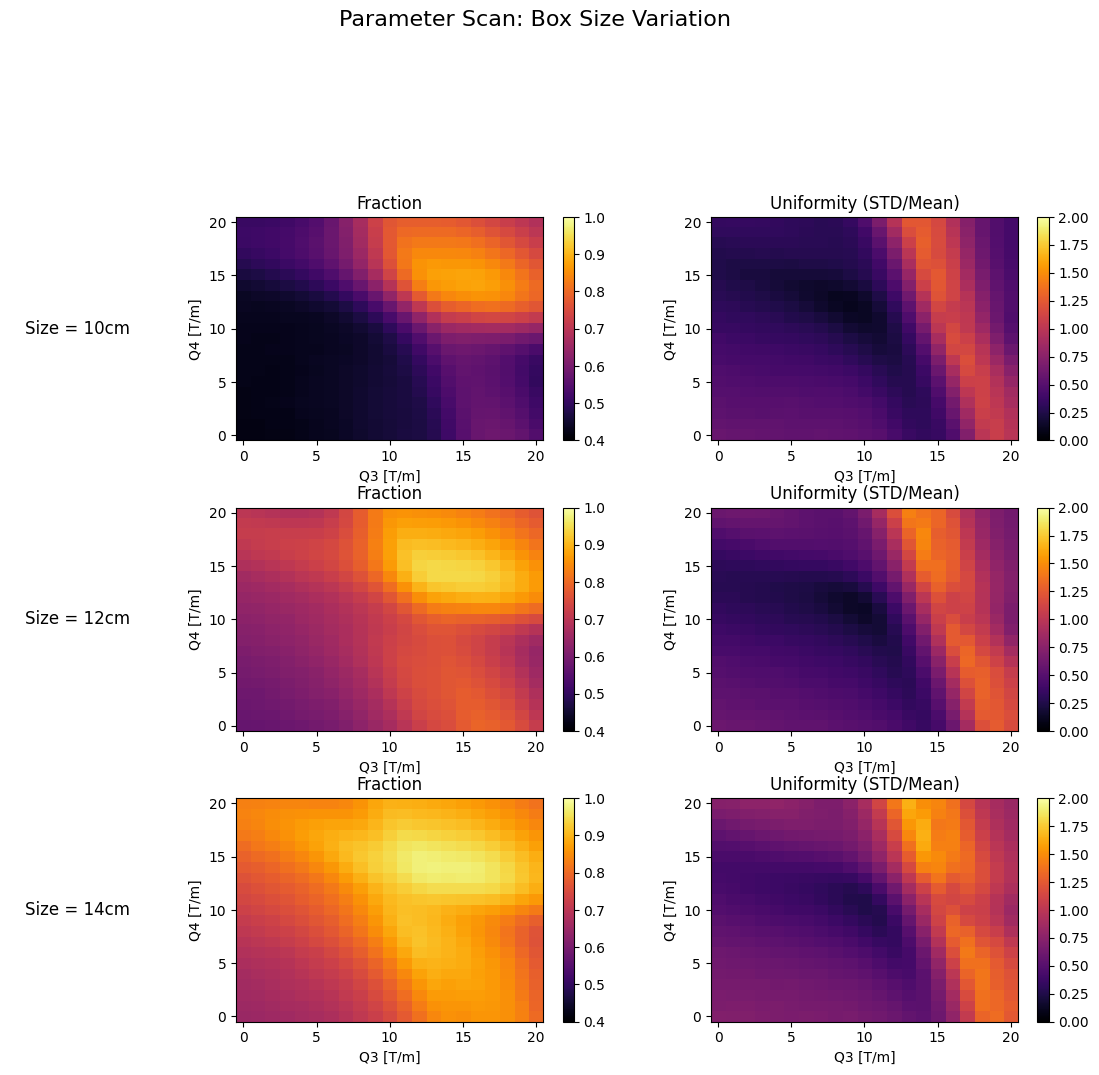

In [27]:
# Visualize results: create heatmaps for all 5 box sizes
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 3, figure=fig, width_ratios=[0.15, 0.425, 0.425], 
              wspace=0.3, hspace=0.3)

q3_vals = np.arange(2, 4.1, 0.1)
q4_vals = np.arange(-4, -1.9, 0.1)  # Reversed for display

for k in range(3):
    size_cm = 5 + k  # 5cm to 9cm
    
    # Text annotation
    ax_text = fig.add_subplot(gs[k, 0])
    ax_text.text(0.5, 0.5, f'Size = {2*size_cm}cm', 
                ha='center', va='center', fontsize=12)
    ax_text.axis('off')
    
    # Fraction heatmap
    ax_frac = fig.add_subplot(gs[k, 1])
    data_frac = merit_size[:, ::-1, k, 0].T
    im1 = ax_frac.imshow(data_frac, aspect='auto', origin='lower',
                         vmin=0.4, vmax=1.0, cmap='inferno')
    ax_frac.set_xlabel('Q3 [T/m]')
    ax_frac.set_ylabel('Q4 [T/m]')
    ax_frac.set_title('Fraction')
    plt.colorbar(im1, ax=ax_frac)
    
    # Uniformity heatmap
    ax_unif = fig.add_subplot(gs[k, 2])
    data_unif = merit_size[:, ::-1, k, 1].T
    im2 = ax_unif.imshow(data_unif, aspect='auto', origin='lower',
                         vmin=0.0, vmax=2.0, cmap='inferno')
    ax_unif.set_xlabel('Q3 [T/m]')
    ax_unif.set_ylabel('Q4 [T/m]')
    ax_unif.set_title('Uniformity (STD/Mean)')
    plt.colorbar(im2, ax=ax_unif)

plt.suptitle('Parameter Scan: Box Size Variation', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Parameter scan: vary octupole strength
# Scan Q3, Q4, and octupole settings
merit_oct = np.zeros((21, 21, 5, 2))

# Get references to Julia objects
O1 = jl.O1
O2 = jl.O2

print("Starting octupole parameter scan...")
start_time = time.time()

for i, q3_b1 in enumerate(np.arange(2, 4.1, 0.1)):
    Q3.Bn1 = q3_b1
    for j, q4_b1 in enumerate(np.arange(-2, -4.1, -0.1)):
        Q4.Bn1 = q4_b1
        for k, o_b3 in enumerate(np.arange(1250, 2251, 250)):
            O1.Bn3 = -o_b3
            O2.Bn3 = o_b3
            
            try:
                # Track bunch
                bunch_tmp = jl.deepcopy(b0)
                jl.track_b(bunch_tmp, nsrl)
                # Compute histogram
                hist_data = hist(bunch_tmp, nx=80, ny=80, make_plot=False)
                # Compute merit
                frac, uniform = box_merit(box(hist_data, h=0.05, v=0.05))
                merit_oct[i, j, k, 0] = frac
                merit_oct[i, j, k, 1] = uniform
            except Exception as e:
                print(f"Error at Q3={q3_b1}, Q4={q4_b1}, O.Bn3={o_b3}: {e}")
                merit_oct[i, j, k, :] = np.nan
    if i % 5 == 0:
        print(f"Progress: {i+1}/21 Q3 values completed")

elapsed = time.time() - start_time
print(f"Octupole scan complete! Elapsed time: {elapsed:.1f} seconds")

In [ ]:
# Visualize octupole scan results
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 3, figure=fig, width_ratios=[0.15, 0.425, 0.425], 
              wspace=0.3, hspace=0.3)

q3_vals = np.arange(2, 4.1, 0.1)
q4_vals = np.arange(-4, -1.9, 0.1)  # Reversed for display

for k in range(5):
    bn3_val = 1250 + 250 * k
    
    # Text annotation
    ax_text = fig.add_subplot(gs[k, 0])
    ax_text.text(0.5, 0.5, f'Bn3 = {bn3_val}\n[T/m³]', 
                ha='center', va='center', fontsize=12)
    ax_text.axis('off')
    
    # Fraction heatmap
    ax_frac = fig.add_subplot(gs[k, 1])
    data_frac = merit_oct[:, ::-1, k, 0].T
    im1 = ax_frac.imshow(data_frac, aspect='auto', origin='lower',
                        extent=[q3_vals[0], q3_vals[-1], q4_vals[0], q4_vals[-1]],
                        cmap='infero')
    ax_frac.set_xlabel('Q3 [T/m]')
    ax_frac.set_ylabel('Q4 [T/m]')
    ax_frac.set_title('Fraction')
    plt.colorbar(im1, ax=ax_frac)
    
    # Uniformity heatmap
    ax_unif = fig.add_subplot(gs[k, 2])
    data_unif = merit_oct[:, ::-1, k, 1].T
    im2 = ax_unif.imshow(data_unif, aspect='auto', origin='lower',
                        extent=[q3_vals[0], q3_vals[-1], q4_vals[0], q4_vals[-1]],
                        cmap='inferno')
    ax_unif.set_xlabel('Q3 [T/m]')
    ax_unif.set_ylabel('Q4 [T/m]')
    ax_unif.set_title('Uniformity (STD/Mean)')
    plt.colorbar(im2, ax=ax_unif)

plt.suptitle('Parameter Scan: Octupole Strength Variation', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

In [29]:
O1 = jl.O1
O2 = jl.O2

In [30]:
# Optimization using scipy
from scipy.optimize import minimize

def objective_func(x):
    """Objective function for optimization"""
    Q3.Bn1 = x[0]
    Q4.Bn1 = x[1]
    O1.Bn3 = -x[2]
    O2.Bn3 = x[2]
    
    # Track bunch
    bunch_tmp = jl.deepcopy(b0)
    jl.track_b(bunch_tmp, nsrl)
    # Compute histogram
    hist_data = hist(bunch_tmp, nx=80, ny=80, make_plot=False)
    # Compute merit
    frac, uniform = box_merit(box(hist_data, h=0.07, v=0.07))
    
    # Cost function: minimize uniformity and penalize low fraction
    cost = uniform + np.exp(50 * (0.75 - frac))
    return cost

# Initial guess
x0 = np.array([2.9, -2.9, 1750.0])

print("Starting optimization with Nelder-Mead...")
print(f"Initial guess: Q3={x0[0]:.2f}, Q4={x0[1]:.2f}, O.Bn3={x0[2]:.1f}")

# Run optimization
result = minimize(objective_func, x0, method='Nelder-Mead', 
                 options={'maxiter': 200, 'disp': True})

bestx = result.x
bestf = result.fun

print(f"\nOptimization complete!")
print(f"Best parameters: Q3.Bn1={bestx[0]:.6f}, Q4.Bn1={bestx[1]:.6f}, O.Bn3={bestx[2]:.6f}")
print(f"Best cost: {bestf:.6f}")

Starting optimization with Nelder-Mead...
Initial guess: Q3=2.90, Q4=-2.90, O.Bn3=1750.0
Optimization terminated successfully.
         Current function value: 0.176555
         Iterations: 60
         Function evaluations: 151

Optimization complete!
Best parameters: Q3.Bn1=2.945477, Q4.Bn1=-2.950352, O.Bn3=1469.613037
Best cost: 0.176555


In [72]:
# Apply optimized parameters and visualize results
Q3.Bn1 = bestx[0]
Q4.Bn1 = bestx[1]
O1.Bn3 = -bestx[2]
O2.Bn3 = bestx[2]

print(f"\nApplying optimized parameters:")
print(f"Q3.Bn1 = {Q3.Bn1:.6f}")
print(f"Q4.Bn1 = {Q4.Bn1:.6f}")
print(f"O1.Bn3 = {O1.Bn3:.6f}")
print(f"O2.Bn3 = {O2.Bn3:.6f}")

# Track with optimized parameters
b_opt = jl.deepcopy(b0)
jl.track_b(b_opt, nsrl)

# Compute merit
hist_opt = hist(b_opt, nx=80, ny=80, make_plot=False)
frac_opt, uniform_opt = box_merit(box(hist_opt, h=0.07, v=0.07))
print(f"\nOptimized merit:")
print(f"Fraction in box: {frac_opt:.4f}")
print(f"Uniformity (STD/Mean): {uniform_opt:.4f}")


Applying optimized parameters:
Q3.Bn1 = 2.945477
Q4.Bn1 = -2.950352
O1.Bn3 = -1469.613037
O2.Bn3 = 1469.613037

Optimized merit:
Fraction in box: 0.8459
Uniformity (STD/Mean): 0.1683


Text(0.5, 0, 'Count')

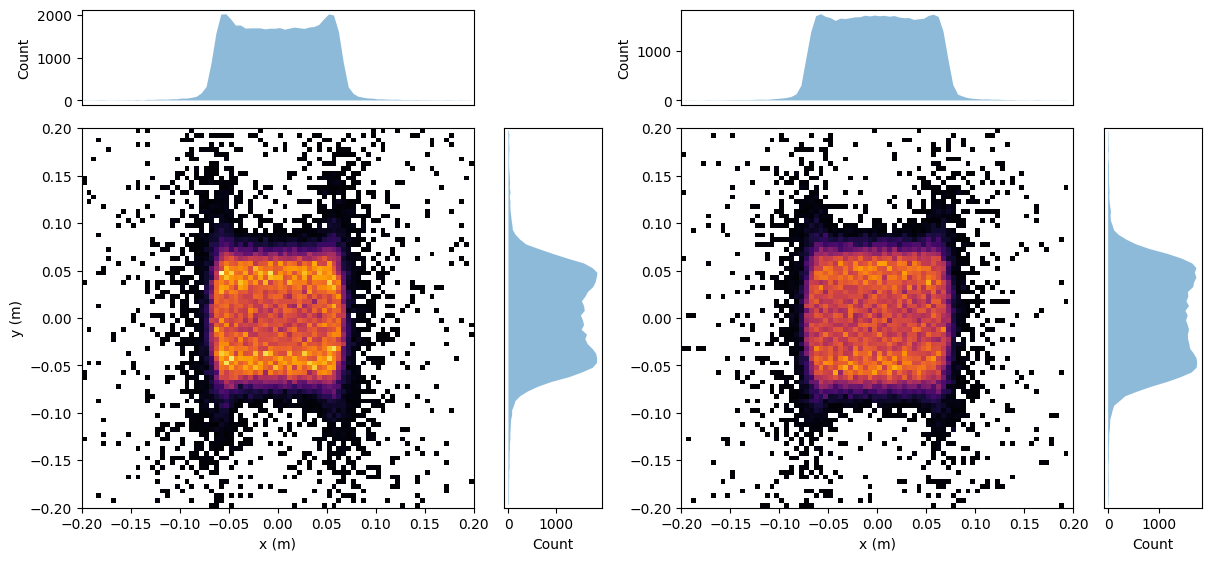

In [102]:
# 1) Reuse your function's "data-only" path
A = hist(bunch, make_plot=False)
B = hist(b_opt, make_plot=False)

# 2) Centers + marginals (from the returned arrays)
x_edges, y_edges = A["x_edges"], A["y_edges"]  # same for B by construction
x_cent = 0.5 * (x_edges[:-1] + x_edges[1:])
y_cent = 0.5 * (y_edges[:-1] + y_edges[1:])

Ax_marg = np.nansum(A["hist"], axis=1)  # sum over y (rows)
Ay_marg = np.nansum(A["hist"], axis=0)  # sum over x (cols)
Bx_marg = np.nansum(B["hist"], axis=1)
By_marg = np.nansum(B["hist"], axis=0)

# 3) Shared color scale
vmin, vmax = 0.0, np.nanmax([np.nanmax(A["hist"]), np.nanmax(B["hist"])])

# 4) Layout: 2 rows × 4 cols → [A_main|A_right|B_main|B_right] with top marginals above mains
fig = plt.figure(figsize=(12, 5.5), constrained_layout=True)
gs  = fig.add_gridspec(2, 4,
                       width_ratios=[0.8, 0.2, 0.8, 0.2],
                       height_ratios=[0.2, 0.8],
                       wspace=0.05, hspace=0.05)

# --- A ---
axA_top   = fig.add_subplot(gs[0,0])
axA_main  = fig.add_subplot(gs[1,0])
axA_right = fig.add_subplot(gs[1,1])

axA_top.fill_between(x_cent, Ax_marg, alpha=0.5)
axA_top.set_xlim((-0.2,0.2)); axA_top.set_xticks([]); axA_top.set_ylabel("Count")

mA = axA_main.pcolormesh(x_edges, y_edges, A["hist"].T, shading="auto",
                         cmap="inferno", vmin=vmin, vmax=vmax)
axA_main.set_xlabel("x (m)"); axA_main.set_ylabel("y (m)")
axA_main.set_aspect('auto')

axA_right.fill_betweenx(y_cent, Ay_marg, alpha=0.5)
axA_right.set_ylim((-0.2,0.2)); axA_right.set_yticks([]); axA_right.set_xlabel("Count")
axA_main.tick_params(labelleft=True, labelbottom=True)


# --- B (share x/y with A for perfect alignment) ---
axB_top   = fig.add_subplot(gs[0,2])
axB_main  = fig.add_subplot(gs[1,2])
axB_right = fig.add_subplot(gs[1,3])


axB_top.fill_between(x_cent, Bx_marg, alpha=0.5)
axB_top.set_xlim((-0.2,0.2)); axB_top.set_xticks([]); axB_top.set_ylabel("Count")

mB = axB_main.pcolormesh(x_edges, y_edges, B["hist"].T, shading="auto",
                         cmap="inferno", vmin=vmin, vmax=vmax)
axB_main.set_xlabel("x (m)")
axB_main.set_aspect('auto')
axB_main.tick_params(labelleft=True, labelbottom=True)

axB_right.fill_betweenx(y_cent, By_marg, alpha=0.5)
axB_right.set_ylim((-0.2,0.2)); axB_right.set_yticks([]); axB_right.set_xlabel("Count")